In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import cv2
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Load dataset
csv_path = r"E:\Rock_fracture_Detection\dataverse_files\train.csv"  # Update this path if needed
df = pd.read_csv(csv_path)

In [4]:
df.head()

,Original Image Patch,Binary Mask Image Patch
0,E:\SEM 6\UG Project\Dataset\dataverse_files\Pa...,E:\SEM 6\UG Project\Dataset\dataverse_files\Pa...
1,E:\SEM 6\UG Project\Dataset\dataverse_files\Pa...,E:\SEM 6\UG Project\Dataset\dataverse_files\Pa...
2,E:\SEM 6\UG Project\Dataset\dataverse_files\Pa...,E:\SEM 6\UG Project\Dataset\dataverse_files\Pa...
3,E:\SEM 6\UG Project\Dataset\dataverse_files\Pa...,E:\SEM 6\UG Project\Dataset\dataverse_files\Pa...
4,E:\SEM 6\UG Project\Dataset\dataverse_files\Pa...,E:\SEM 6\UG Project\Dataset\dataverse_files\Pa...


In [21]:
# Select only a subset of 220 images (200 for training, 20 for testing)
df = df.sample(n=220, random_state=42).reset_index(drop=True)

In [22]:
# Function to load images
def load_image(image_path, mask_path, size=(224, 224)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    mask = cv2.resize(mask, size)
    image = image / 255.0  # Normalize
    mask = mask / 255.0  # Normalize
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    return image, mask

In [23]:
# Load selected images and masks
image_paths = df['Original Image Patch'].values
mask_paths = df['Binary Mask Image Patch'].values
images, masks = zip(*[load_image(img, mask) for img, mask in zip(image_paths, mask_paths)])
images, masks = np.array(images), np.array(masks)

In [24]:
# Split dataset into 200 training and 20 testing images
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=20/220, random_state=42)

In [25]:
# U-Net Model
def unet_model(input_size=(224, 224, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.concatenate([u4, c2])
    
    u5 = layers.UpSampling2D((2, 2))(u4)
    u5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.concatenate([u5, c1])
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u5)
    
    model = Model(inputs, outputs)
    return model

In [26]:
# Compile Model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [27]:
# Train Model
model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test))

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 658s 13s/step - accuracy: 0.8641 - loss: 0.3657 - val_accuracy: 0.9453 - val_loss: 0.2404
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 654s 13s/step - accuracy: 0.9458 - loss: 0.2152 - val_accuracy: 0.9453 - val_loss: 0.2176
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 592s 12s/step - accuracy: 0.9444 - loss: 0.2041 - val_accuracy: 0.9453 - val_loss: 0.2028
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 628s 13s/step - accuracy: 0.9471 - loss: 0.1869 - val_accuracy: 0.9453 - val_loss: 0.1692
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 649s 13s/step - accuracy: 0.9485 - loss: 0.1694 - val_accuracy: 0.9454 - val_loss: 0.1563
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 426s 8s/step - accuracy: 0.9442 - loss: 0.1502 - val_accuracy: 0.9477 - val_loss: 0.1419
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 423s 8s/step - accuracy: 0.9521 - loss: 0.1343 - val_accuracy: 0.9477 - val_loss: 0.1560
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 573s 11s/step - accuracy: 0.9483 - loss: 0.1404 - val_accuracy: 0.95

In [28]:
# Save Model
model.save("unet_rock_fracture_prototype.h5")

In [29]:
# Evaluate Model
eval_results = model.evaluate(X_test, y_test)
print(f"Test Loss: {eval_results[0]:.4f}, Test Accuracy: {eval_results[1]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.9556 - loss: 0.1130
Test Loss: 0.1130, Test Accuracy: 0.9556


In [36]:
# Display an example prediction
sample_idx = np.random.randint(len(X_test))
sample_image = X_test[sample_idx]
sample_mask = y_test[sample_idx]
predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


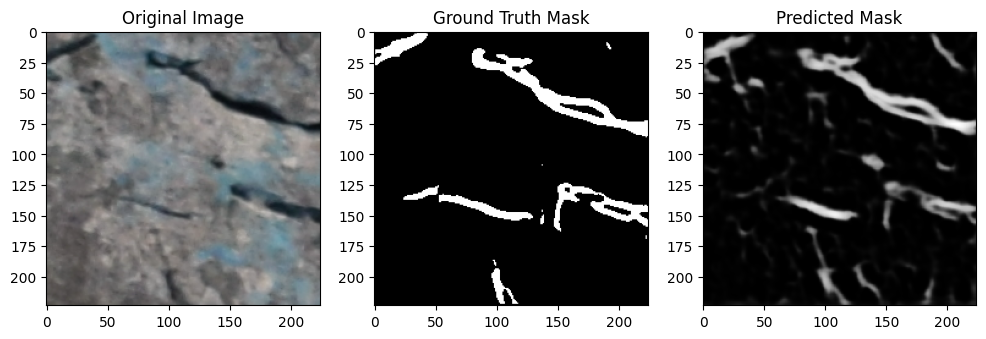

In [37]:
# Plot original image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(sample_mask[:, :, 0], cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask[:, :, 0], cmap='gray')
plt.title("Predicted Mask")
plt.show()